# Capstone Project - Battle of Neighborhoods
## Opening a Scandinavian Restaurant in Toronto, Canada

### 1. Introduction/Business Problem

The inspiration for this subject comes from personal experience, having explored Scandinavian countries over the past years. I love their culture and food, but there is little to no opportunity to experience any of that outside of Scandinavia. The few places that do have certain elements of this cuisine lack the hygge feeling that makes the picture whole. 

This project aims to find the best location to open such a restaurant in Toronto.
While there is little competition, I will be analyzing restaurants with similar cuisine, such as places specialized in serving fish or French restaurants, whoch also offer seafood and their dessert choices are very similar.


This project aims to find the perfect location to open such a restaurant in Toronto. It could also be used by anyone else thinking about opening an unusual restaurant with little to no direct competition in the city.

### 2. Data

For this project I need to use a combination of data that is available online and also the Foursquare API.

-List of postal codes and neighbourhoods in Canada (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

-Geospaial data in a csv format to get the longitude and latitude values used for plotting (https://cocl.us/Geospatial_data)
    
-Foursquare API data about venues, which will help me categorize and group the restaurants

The data section is inspired by the practice notebook from the course.


### 3. Methodology

#### Data transformations
I started by gathering the data, cleanining and combining the necessary data souces to get the data ready for analysis and clustering.

After getting the base data from the wikipedia page, I merged it with the Geocoder csv data to get the whole picture of Toronto geographically. As a next step I extracted the venue fata from Foursquare and merged it with the previous dataframe, thus making the picture whole and my data ready for analysis. 
I used an older Foursquare API version, since the corona outbreak changed the restaurant landscape and I an optimist, I would like to have a picture of the world before and after the pandemic.

As I previously mentioned, I found no direct competition, since theer are no Scandianvian restaurants per se in the data, so I resorted to grouping venues which serve similar cousines. I chose venues serving fish and french restaurants and potential competitors, created a modified category in my data for them and then worked with this modified category when clutering.

For the machine learning part I first created dummy data with one hot encoding to make my data numerical and suitable for the algorithm. I then simplified this dataset to only show neighborhoods and the mean frequency of potential competitor restaurants.

#### Kmeans Clustering
I decided to do the clustering based on the neighbourhoods that had similar averages of potential competitors in the area. 
For deciding upon the optimum k value, I resorted to the Elbow Point technique, which suggested that a k of 4 would be ideal in my case.
I then created a map using the Folium package to visualize the clusters. This is very important, since a location close to the sea would go prefectly with the vibe of the restaurant. 
When deicing upon the perfect location, I looked at the number of potential competitors per cluster and that, together with the location is very valuable when choosing where our Scandinavian resturant should be.


In [1]:
#Foursquare API Secrets used for authentication
#I used an older API version, since the corona outbreak affects the current data.

CLIENT_ID = "***********************"
CLIENT_SECRET = "************************"
google_api_key = "*********************"
VERSION = '20190801'

In [2]:
# import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
print('Packages installed.')

Packages installed.


## Data Import, Transformation and Plotting

In [3]:
# Getting the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

In [4]:
# reading the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())

In [5]:
df = pd.read_html(table_str)[0]
df.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

In [8]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)

In [9]:
df_dropna.rename(columns={'Postal Code' : 'PostalCode'}, inplace=True)

In [10]:
df = df_dropna

In [11]:
df.head()

PostalCode           Borough                                Neighbourhood
0        M3A        North York                                    Parkwoods
1        M4A        North York                             Victoria Village
2        M5A  Downtown Toronto                    Regent Park, Harbourfront
3        M6A        North York             Lawrence Manor, Lawrence Heights
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [12]:
df_grouped = df.groupby(['Borough', 'PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

Borough PostalCode                      Neighbourhood
0  Central Toronto        M4N                      Lawrence Park
1  Central Toronto        M4P                   Davisville North
2  Central Toronto        M4R  North Toronto West, Lawrence Park
3  Central Toronto        M4S                         Davisville
4  Central Toronto        M4T        Moore Park, Summerhill East

In [13]:
df = df_grouped
df.shape

(103, 3)

In [14]:
df.columns

Index(['Borough', 'PostalCode', 'Neighbourhood'], dtype='object')

In [15]:
#importing the langitude and latitude data
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [16]:
#combining(merging) the data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

Borough PostalCode                      Neighbourhood   Latitude  \
0  Central Toronto        M4N                      Lawrence Park  43.728020   
1  Central Toronto        M4P                   Davisville North  43.712751   
2  Central Toronto        M4R  North Toronto West, Lawrence Park  43.715383   
3  Central Toronto        M4S                         Davisville  43.704324   
4  Central Toronto        M4T        Moore Park, Summerhill East  43.689574   

   Longitude  
0 -79.388790  
1 -79.390197  
2 -79.405678  
3 -79.388790  
4 -79.383160

In [19]:
#df_toronto = df
#df_toronto.head()

Borough PostalCode                      Neighbourhood   Latitude  \
0  Central Toronto        M4N                      Lawrence Park  43.728020   
1  Central Toronto        M4P                   Davisville North  43.712751   
2  Central Toronto        M4R  North Toronto West, Lawrence Park  43.715383   
3  Central Toronto        M4S                         Davisville  43.704324   
4  Central Toronto        M4T        Moore Park, Summerhill East  43.689574   

   Longitude  
0 -79.388790  
1 -79.390197  
2 -79.405678  
3 -79.388790  
4 -79.383160

In [17]:
#list with the boroughs (to be used later)
boroughs = df['Borough'].unique().tolist()

In [18]:
lat_toronto = df['Latitude'].mean()
lon_toronto = df['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165047


In [19]:
#importing additional libraries
from IPython.display import Image 
from IPython.core.display import HTML 
from geopy.geocoders import Nominatim 
from IPython.display import display_html
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: ...working... done

# All requested packages already installed.



In [20]:
!pip install lxml
!pip install geopy

In [21]:
# Visualizing the neighborhoods of the above df using Folium
map_toronto = folium.Map(location=[43.70460,-79.347015],zoom_start=11)

for lat,lng,borough,neighbourhood in zip(df['Latitude'],df['Longitude'],df['Borough'],df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='teal',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

In [22]:
#get the top 100 venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude'])

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [25]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                             
Agincourt                                                            5   
Alderwood, Long Branch                                               7   
Bathurst Manor, Wilson Heights, Downsview North                     21   
Bayview Village                                                      4   
Bedford Park, Lawrence Manor East                                   22   
...                                                                ...   
Willowdale, Willowdale West                                          5   
Woburn                                                               4   
Woodbine Heights                                                     8   
York Mills West                                                      2   
York Mills, Silver Hills                                             1   

                                                 Neighborhood Longitude  \
Neighborhood                                                              
Agincourt                                                             5   
Alderwood, Long Branch                                                7   
Bathurst Manor, Wilson Heights, Downsview North                      21   
Bayview Village                                                       4   
Bedford Park, Lawrence Manor East                                    22   
...                                                                 ...   
Willowdale, Willowdale West                                           5   
Woburn                                                                4   
Woodbine Heights                                                      8   
York Mills West                                                       2   
York Mills, Silver Hills                                              1   

                                                 Venue  Venue Latitude  \
Neighborhood                                                             
Agincourt                                            5               5   
Alderwood, Long Branch                               7               7   
Bathurst Manor, Wilson Heights, Downsview North     21              21   
Bayview Village                                      4               4   
Bedford Park, Lawrence Manor East                   22              22   
...                                                ...             ...   
Willowdale, Willowdale West                          5               5   
Woburn                                               4               4   
Woodbine Heights                                     8               8   
York Mills West                                      2               2   
York Mills, Silver Hills                             1               1   

                                                 Venue Longitude  \
Neighborhood                                                       
Agincourt                                                      5   
Alderwood, Long Branch                                         7   
Bathurst Manor, Wilson Heights, Downsview North               21   
Bayview Village                                                4   
Bedford Park, Lawrence Manor East                             22   
...                                                          ...   
Willowdale, Willowdale West                                    5   
Woburn                                                         4   
Woodbine Heights                                               8   
York Mills West                                                2   
York Mills, Silver Hills                                       1   

                                                 Venue Category  
Neighborhood                                                     
Agincourt                                                     5  
Alderwood, Long Branch                                        7 

In [26]:
toronto_venues['Venue Category'].value_counts()

Coffee Shop          190
Café                  93
Restaurant            67
Park                  51
Pizza Place           49
                    ... 
Airport Gate           1
Afghan Restaurant      1
Church                 1
Organic Grocery        1
College Gym            1
Name: Venue Category, Length: 273, dtype: int64

In [27]:
#Looking for venues with similar categories, to create my own "Potential Competitor" label
competitors = toronto_venues[toronto_venues['Venue Category'].str.contains("Nordic|Scandinavian|Swedish|Fish|French")]
competitors

Neighborhood  Neighborhood Latitude  \
253                   Regent Park, Harbourfront              43.654260   
427                              St. James Town              43.651494   
433                              St. James Town              43.651494   
474                                 Berczy Park              43.644771   
481                                 Berczy Park              43.644771   
563                          Central Bay Street              43.657952   
848    Toronto Dominion Centre, Design Exchange              43.647177   
927              Commerce Court, Victoria Hotel              43.648198   
993              University of Toronto, Harbord              43.662696   
1034  Kensington Market, Chinatown, Grange Park              43.653206   
1119                             Stn A PO Boxes              43.646435   
1136                             Stn A PO Boxes              43.646435   
1400             India Bazaar, The Beaches West              43.668999   
1422                            Studio District              43.659526   
1492                                    Leaside              43.709060   
1829                           Victoria Village              43.725882   
1998                   Little Portugal, Trinity              43.647927   
2088                         Runnymede, Swansea              43.651571   
2099                         Runnymede, Swansea              43.651571   

      Neighborhood Longitude                       Venue  Venue Latitude  \
253               -79.360636  Cluny Bistro & Boulangerie       43.650565   
427               -79.375418        Seafront Fish Market       43.648479   
433               -79.375418               Biff's Bistro       43.647085   
474               -79.373306               Biff's Bistro       43.647085   
481               -79.373306        Seafront Fish Market       43.648479   
563               -79.387383                 Midi Bistro       43.655871   
848               -79.381576               Biff's Bistro       43.647085   
927               -79.379817               Biff's Bistro       43.647085   
993               -79.400049                 Cafe Cancan       43.662735   
1034              -79.400049                      Hooked       43.654585   
1119              -79.374846               Biff's Bistro       43.647085   
1136              -79.374846        Seafront Fish Market       43.648479   
1400              -79.315572  British Style Fish & Chips       43.668723   
1422              -79.340923                      Hooked       43.660407   
1492              -79.363452     Olde Yorke Fish & Chips       43.706141   
1829              -79.315572                    The Frig       43.727051   
1998              -79.419750                   La Banane       43.649040   
2088              -79.484450       The One That Got Away       43.649842   
2099              -79.484450   Amber European Restaurant       43.649946   

      Venue Longitude     Venue Category  
253        -79.357843  French Restaurant  
427        -79.371489        Fish Market  
433        -79.376342  French Restaurant  
474        -79.376342  French Restaurant  
481        -79.371489        Fish Market  
563        -79.392091  French Restaurant  
848        -79.376342  French Restaurant  
927        -79.376342  French Restaurant  
993        -79.403447  French Restaurant  
1034       -79.401746        Fish Market  
1119       -79.376342  French Restaurant  
1136       -79.371489        Fish Market  
1400       -79.317139  Fish & Chips Shop  
1422       -79.343257        Fish Market  
1492       -79.361829  Fish & Chips Shop  
1829       -79.317418  French Restaurant  
1998       -79.420599  French Restaurant  
2088       -79.482615  Fish & Chips Shop  
2099       -79.482009  French Restaurant

In [28]:
competitors['Venue Category'].value_counts()

French Restaurant    11
Fish Market           5
Fish & Chips Shop     3
Name: Venue Category, dtype: int64

In [29]:
#adding my modified category column to group the competition
toronto_venues['Category Modified'] = toronto_venues['Venue Category']

In [30]:
toronto_venues['Category Modified'] = toronto_venues['Category Modified'].replace(['French Restaurant','Fish Market','Fish & Chips Shop'],'Potential Competition')

In [31]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [32]:
toronto_venues

Neighborhood  \
0                                         Lawrence Park   
1                                         Lawrence Park   
2                                         Lawrence Park   
3                                      Davisville North   
4                                      Davisville North   
5                                      Davisville North   
6                                      Davisville North   
7                                      Davisville North   
8                                      Davisville North   
9                                      Davisville North   
10                                     Davisville North   
11                                     Davisville North   
12                    North Toronto West, Lawrence Park   
13                    North Toronto West, Lawrence Park   
14                    North Toronto West, Lawrence Park   
15                    North Toronto West, Lawrence Park   
16                    North Toronto West, Lawrence Park   
17                    North Toronto West, Lawrence Park   
18                    North Toronto West, Lawrence Park   
19                    North Toronto West, Lawrence Park   
20                    North Toronto West, Lawrence Park   
21                    North Toronto West, Lawrence Park   
22                    North Toronto West, Lawrence Park   
23                    North Toronto West, Lawrence Park   
24                    North Toronto West, Lawrence Park   
25                    North Toronto West, Lawrence Park   
26                    North Toronto West, Lawrence Park   
27                    North Toronto West, Lawrence Park   
28                    North Toronto West, Lawrence Park   
29                    North Toronto West, Lawrence Park   
30                                           Davisville   
31                                           Davisville   
32                                           Davisville   
33                                           Davisville   
34                                           Davisville   
35                                           Davisville   
36                                           Davisville   
37                                           Davisville   
38                                           Davisville   
39                                           Davisville   
40                                           Davisville   
41                                           Davisville   
42                                           Davisville   
43                                           Davisville   
44                                           Davisville   
45                                           Davisville   
46                                           Davisville   
47                                           Davisville   
48                                           Davisville   
49                                           Davisville   
50                                           Davisville   
51                                           Davisville   
52                                           Davisville   
53                                           Davisville   
54                                           Davisville   
55                                           Davisville   
56                                           Davisville   
57                                           Davisville   
58                                           Davisville   
59                                           Davisville   
60                                           Davisville   
61                                           Davisville   
62                                           Davisville   
63                          Moore Park, Summerhill East   
64                          Moore Park, Summerhill East   
65    Summerhill West, Rathnelly, South Hill, Forest...   
66    Summerhill West, Rathnelly, South Hill, Forest...   
67    Summerhill West, Rathnell

In [33]:
# one hot encoding
dummies = pd.get_dummies(toronto_venues[['Category Modified']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dummies['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dummies.columns[-1]] + list(dummies.columns[:-1])
dummies = dummies[fixed_columns]

print(dummies.shape)
dummies.head()

(2141, 272)


Neighborhoods  Accessories Store  Afghan Restaurant  Airport  \
0     Lawrence Park                  0                  0        0   
1     Lawrence Park                  0                  0        0   
2     Lawrence Park                  0                  0        0   
3  Davisville North                  0                  0        0   
4  Davisville North                  0                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0           0                    0                 0                   0   
1           0                    0                 0                   0   
2           0                    0                 0                   0   
3           0                    0                 0                   0   
4           0                    0                 0                   0   

   Auto Garage  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0            0              0          0           0           0       0   
1            0              0          0           0           0       0   
2            0              0          0           0           0       0   
3            0              0          0           0           0       0   
4            0              0          0           0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Stadium  Beach  \
0     0    0               0                 0                   0      0   
1     0    0               0                 0                   0      0   
2     0    0               0                 0                   0      0   
3     0    0               0                 0                   0      0   
4     0    0               0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bike Shop  \
0                0         0           0                   0          0   
1                0         0           0                   0          0   
2                0         0           0                   0          0   
3                0         0           0                   0          0   
4                0         0           0                   0          0   

   Bistro  Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  \
0       0              0          0         0                     0   
1       0              0          0         0                     0   
2       0              0          0         0                     0   
3       0              0          0         0                     0   
4       0              0          0         0                     0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Building  \
0               0        0            0                0         0   
1               0        0            0                0         0   
2               0        0            0                0         0   
3               1        0            0                0         0   
4               0        0            0                0    

In [34]:
grouped = dummies.groupby(["Neighborhoods"]).mean().reset_index()

print(grouped.shape)
grouped.head()

(96, 272)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0                0.0      0.0                 0.0           0.0   
1                0.0      0.0                 0.0           0.0   
2                0.0      0.0                 0.0           0.0   
3                0.0      0.0                 0.0           0.0   
4                0.0      0.0                 0.0           0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0             0.000000   
1             0.0              0.0               0.0             0.000000   
2             0.0              0.0               0.0             0.000000   
3             0.0              0.0               0.0             0.000000   
4             0.0              0.0               0.0             0.045455   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
0           0.0       0.0          0.0         0.0                  0.0   
1           0.0       0.0          0.0         0.0                  0.0   
2           0.0       0.0          0.0         0.0                  0.0   
3           0.0       0.0          0.0         0.0                  0.0   
4           0.0       0.0          0.0         0.0                  0.0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Auto Workshop  \
0               0.0                 0.0          0.0            0.0   
1               0.0                 0.0          0.0            0.0   
2               0.0                 0.0          0.0            0.0   
3               0.0                 0.0          0.0            0.0   
4               0.0                 0.0          0.0            0.0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery      Bank  Bar  Baseball Field  \
0        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   
1        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   
2        0.0         0.0         0.0     0.0  0.095238  0.0             0.0   
3        0.0         0.0         0.0     0.0  0.250000  0.0             0.0   
4        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   

   Baseball Stadium  Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  \
0               0.0                 0.0    0.0              0.0       0.0   
1               0.0                 0.0    0.0              0.0       0.0   
2               0.0                 0.0    0.0              0.0       0.0   
3               0.0                 0.0    0.0              0.0       0.0   
4               0.0                 0.0    0.0              0.0       0.0   

   Beer Store  Belgian Restaurant  Bike Shop  Bistro  Boat or Ferry  \
0         0.0                 0.0        0.0     0.0            0.0   
1         0.0                 0.0        0.0     0.0            0.0   
2         0.0                 0.0        0.0     0.0            0.0   
3         0.0                 0.0        0.0     0.0            0.0   
4         0.0                 0.0        0.0     0.0            0.0   

   Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  \
0        0.0       0.0                   0.0             0.2      0.0   
1        0.0       0.0                   0.0             0.0      0.0   
2        0.0       0.0                   0.0             0.0      0.0   
3        0.0       0.0                   0.0             0.0      0.0   
4        0.0       0.0                   0.0             0.0      0.0   

   Bridal Shop  Bubble Tea Shop  Building  Burger 

## Data Analysis, clustering

In [35]:
comp = grouped[["Neighborhoods","Potential Competition"]]
comp

Neighborhoods  Potential Competition
0                                           Agincourt               0.000000
1                              Alderwood, Long Branch               0.000000
2     Bathurst Manor, Wilson Heights, Downsview North               0.000000
3                                     Bayview Village               0.000000
4                   Bedford Park, Lawrence Manor East               0.000000
5                                         Berczy Park               0.036364
6                         Birch Cliff, Cliffside West               0.000000
7        Brockton, Parkdale Village, Exhibition Place               0.000000
8   Business reply mail Processing Centre, South C...               0.000000
9   CN Tower, King and Spadina, Railway Lands, Har...               0.000000
10                                Caledonia-Fairbanks               0.000000
11              Canada Post Gateway Processing Centre               0.000000
12                                          Cedarbrae               0.000000
13                                 Central Bay Street               0.014706
14                                           Christie               0.000000
15                               Church and Wellesley               0.000000
16            Clarks Corners, Tam O'Shanter, Sullivan               0.000000
17    Cliffside, Cliffcrest, Scarborough Village West               0.000000
18                     Commerce Court, Victoria Hotel               0.010000
19                                         Davisville               0.000000
20                                   Davisville North               0.000000
21   Del Ray, Mount Dennis, Keelsdale and Silverthorn               0.000000
22                                          Don Mills               0.000000
23  Dorset Park, Wexford Heights, Scarborough Town...               0.000000
24                                          Downsview               0.000000
25                       Dufferin, Dovercourt Village               0.000000
26      East Toronto, Broadview North (Old East York)               0.000000
27  Eringate, Bloordale Gardens, Old Burnhamthorpe...               0.000000
28                       Fairview, Henry Farm, Oriole               0.000000
29             First Canadian Place, Underground city               0.000000
30    Forest Hill North & West, Forest Hill Road Park               0.000000
31                           Garden District, Ryerson               0.000000
32                                          Glencairn               0.000000
33                    Golden Mile, Clairlea, Oakridge               0.000000
34                  Guildwood, Morningside, West Hill               0.000000
35  Harbourfront East, Union Station, Toronto Islands               0.000000
36                      High Park, The Junction South               0.000000
37                                  Hillcrest Village               0.000000
38                                      Humber Summit               0.000000
39                                   Humberlea, Emery               0.000000
40                                 Humewood-Cedarvale               0.000000
41                     India Bazaar, The Beaches West               0.052632
42        Kennedy Park, Ionview, East Birchmount Park               0.000000
43          Kensington Market, Chinatown, Grange Park               0.013514
44  Kingsview Village, St. Phillips, Martin Grove ...               0.000000
45                   Lawrence Manor, Lawrence Heights               0.000000
46                                      Lawrence Park               0.000000
47                                            Leaside               0.030303
48                           Little Portugal, Trinity               0.022222
49                                     Malvern, Rouge               0.000000
50  Milliken, Agincourt North, Steeles East, L'Amo...               0.000000
51  Mimico NW, The Queensway West, S

In [36]:
comp = comp.rename(columns={'Neighborhoods':'Neighborhood'})

In [37]:
#clustering the neighborhoods with k-means clustering
#finding the best K using the Elbow Point method
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = comp.drop(['Neighborhood'], axis=1)


In [38]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0])

In [39]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [40]:
scores = [get_inertia(x) for x in range(2, 21)]

C:\Users\ONagy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ONagy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ONagy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ONagy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (19). Possibly 

Text(0, 0.5, 'Error')

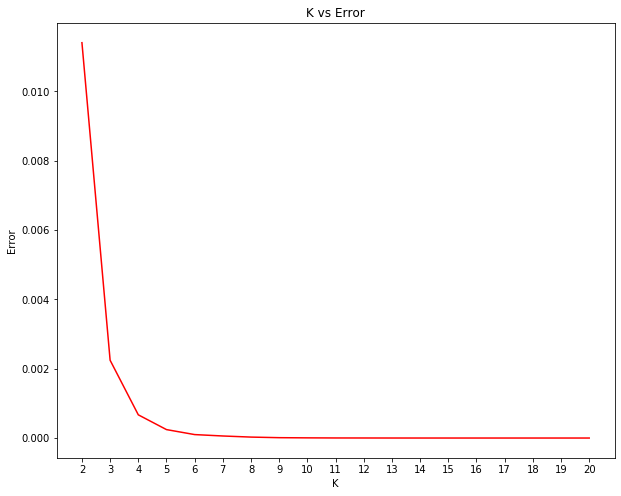

In [67]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [44]:
#the steepest points seems to be at either 3 or 4, but I will choose 4, since it will give me more options afterwards
k = 4

toronto_grouped_clustering = comp.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0])

In [46]:
# new dataframe that includes the clusters as well as the top venues for each neighborhood
merged = comp.copy()

# add clustering labels
merged["Cluster Labels"] = kmeans.labels_

In [47]:
merged.head()

Neighborhood  Potential Competition  \
0                                        Agincourt                    0.0   
1                           Alderwood, Long Branch                    0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                    0.0   
3                                  Bayview Village                    0.0   
4                Bedford Park, Lawrence Manor East                    0.0   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               0

In [48]:
# adding latitude and longitude for each neighborhood
merged = merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(merged.shape)

(2141, 10)


In [49]:
merged.head()

Neighborhood  Potential Competition  Cluster Labels  Neighborhood Latitude  \
0    Agincourt                    0.0               0                43.7942   
0    Agincourt                    0.0               0                43.7942   
0    Agincourt                    0.0               0                43.7942   
0    Agincourt                    0.0               0                43.7942   
0    Agincourt                    0.0               0                43.7942   

   Neighborhood Longitude                        Venue  Venue Latitude  \
0              -79.262029  Panagio's Breakfast & Lunch       43.792370   
0              -79.262029                El Pulgarcito       43.792648   
0              -79.262029                     Twilight       43.791999   
0              -79.262029                       Mark's       43.791179   
0              -79.262029              Commander Arena       43.794867   

   Venue Longitude             Venue Category          Category Modified  
0       -79.260203             Breakfast Spot             Breakfast Spot  
0       -79.259208  Latin American Restaurant  Latin American Restaurant  
0       -79.258584                     Lounge                     Lounge  
0       -79.259714             Clothing Store             Clothing Store  
0       -79.267989               Skating Rink               Skating Rink

In [50]:
# sorting the results
print(merged.shape)
merged.sort_values(["Cluster Labels"], inplace=True)
merged

(2141, 10)


Neighborhood  Potential Competition  \
0                                           Agincourt               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
54           North Park, Maple Leaf Park, Upwood Park               0.000000   
54           North Park, Maple Leaf Park, Upwood Park               0.000000   
54           North Park, Maple Leaf Park, Upwood Park               0.000000   
53       New Toronto, Mimico South, Humber Bay Shores               0.000000   
53       New Toronto, Mimico South, Humber Bay Shores               0.000000   
53       New Toronto, Mimico South, Humber Bay Shores               0.000000   
53       New Toronto, Mimico South, Humber Bay Shores               0.000000   
53       New Toronto, Mimico South, Humber Bay Shores               0.000000   
53       New Toronto, Mimico South, Humber Bay Shores               0.000000   
53       New Toronto, Mimico South, Humber Bay Shores               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
59                             Parkdale, Roncesvalles               0.000000   
59                             Parkdale, Roncesvalles               0.000000   
59                             Parkdale, Roncesvalles               0.000000   
59                             Parkdale, Roncesvalles               0.000000   
59                             Parkdale, Roncesvalles               0.000000   
59                             Parkdale, Roncesvalles               0.000000   
58  Old Mill South, King's Mill Park, Sunnylea, Hu...               0.000000   
58  Old Mill South, King's Mill Park, Sunnylea, Hu...               0.000000   
57                    Northwood Park, York University               0.000000   
57                    Northwood Park, York University               0.000000   
53       New Toronto, Mimico South, Humber Bay Shores               0.000000   
57                    Northwood Park, York University               0.000000   
57                    Northwood Park, York University               0.000000   
57                    Northwood Park, York University               0.000000   
57                    Northwood Park, York University               0.000000   
56                Northwest, West Humber - Clairville               0.000000   
56                Northwest, West Humber - Clairville               0.000000   
56                Northwest, West Humber - Clairville               0.000000   
56                Northwest, West Humber - Clairville               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
55                  North Toronto West, Lawrence Park               0.000000   
57                    Northwood Park, York University               0.000000   
59                             Parkdale, 

In [51]:
merged['Category Modified'].value_counts()['Potential Competition']

19

In [54]:
merged['Cluster Labels'] = merged['Cluster Labels'].replace([0,1,2,3],[1,2,3,4])

In [55]:
merged['Cluster Labels'].value_counts()

1    1512
3     571
4      52
2       6
Name: Cluster Labels, dtype: int64

In [57]:
# showing the clusters on a map
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# setting the color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(merged['Neighborhood Latitude'], merged['Neighborhood Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [58]:
#number of neighborhoods per Cluster
comp["Cluster Labels"] = kmeans.labels_
comp.head()

Neighborhood  Potential Competition  \
0                                        Agincourt                    0.0   
1                           Alderwood, Long Branch                    0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                    0.0   
3                                  Bayview Village                    0.0   
4                Bedford Park, Lawrence Manor East                    0.0   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               0

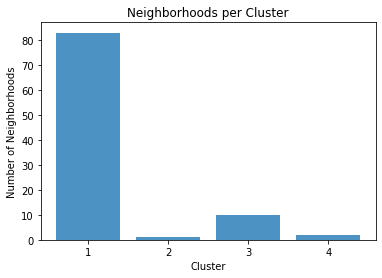

In [74]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = comp['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Neighborhoods per Cluster')

plt.show()

In [61]:
# How many neighborhoods in each cluster
comp['Cluster Labels'].value_counts()

0    83
2    10
3     2
1     1
Name: Cluster Labels, dtype: int64

### Analysis of each Cluster separately

In [62]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighbourhood']]
df_new.head()

Borough                      Neighbourhood
0  Central Toronto                      Lawrence Park
1  Central Toronto                   Davisville North
2  Central Toronto  North Toronto West, Lawrence Park
3  Central Toronto                         Davisville
4  Central Toronto        Moore Park, Summerhill East

In [63]:
df_new.columns =['Borough', 'Neighborhood']

In [64]:
df_new.head()

Borough                       Neighborhood
0  Central Toronto                      Lawrence Park
1  Central Toronto                   Davisville North
2  Central Toronto  North Toronto West, Lawrence Park
3  Central Toronto                         Davisville
4  Central Toronto        Moore Park, Summerhill East

Cluster 1 - large area with no competition, but bad location

In [65]:
# purple

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')

In [66]:
df_cluster1

Borough                                       Neighborhood  \
0    Central Toronto                                      Lawrence Park   
1    Central Toronto                                   Davisville North   
2    Central Toronto                  North Toronto West, Lawrence Park   
3    Central Toronto                                         Davisville   
4    Central Toronto                        Moore Park, Summerhill East   
5    Central Toronto  Summerhill West, Rathnelly, South Hill, Forest...   
6    Central Toronto                                           Roselawn   
7    Central Toronto    Forest Hill North & West, Forest Hill Road Park   
8    Central Toronto                The Annex, North Midtown, Yorkville   
9   Downtown Toronto                                           Rosedale   
10  Downtown Toronto                        St. James Town, Cabbagetown   
11  Downtown Toronto                               Church and Wellesley   
12  Downtown Toronto                           Garden District, Ryerson   
13  Downtown Toronto                           Richmond, Adelaide, King   
14  Downtown Toronto  Harbourfront East, Union Station, Toronto Islands   
15  Downtown Toronto           Toronto Dominion Centre, Design Exchange   
16  Downtown Toronto                     Commerce Court, Victoria Hotel   
17  Downtown Toronto  CN Tower, King and Spadina, Railway Lands, Har...   
18  Downtown Toronto             First Canadian Place, Underground city   
19  Downtown Toronto                                           Christie   
20  Downtown Toronto        Queen's Park, Ontario Provincial Government   
21      East Toronto                                        The Beaches   
22      East Toronto                       The Danforth West, Riverdale   
23      East Toronto  Business reply mail Processing Centre, South C...   
24         East York                    Parkview Hill, Woodbine Gardens   
25         East York                                   Woodbine Heights   
26         East York                                   Thorncliffe Park   
27         East York      East Toronto, Broadview North (Old East York)   
28         Etobicoke       New Toronto, Mimico South, Humber Bay Shores   
29         Etobicoke                             Alderwood, Long Branch   
30         Etobicoke      The Kingsway, Montgomery Road, Old Mill North   
31         Etobicoke  Old Mill South, King's Mill Park, Sunnylea, Hu...   
32         Etobicoke  Mimico NW, The Queensway West, South of Bloor,...   
33         Etobicoke  West Deane Park, Princess Gardens, Martin Grov...   
34         Etobicoke  Eringate, Bloordale Gardens, Old Burnhamthorpe...   
35         Etobicoke                                          Westmount   
36         Etobicoke  Kingsview Village, St. Phillips, Martin Grove ...   
37         Etobicoke  South Steeles, Silverstone, Humbergate, Jamest...   
38         Etobicoke                Northwest, West Humber - Clairville   
39       Mississauga              Canada Post Gateway Processing Centre   
40        North York                                  Hillcrest Village   
41        North York                       Fairview, Henry Farm, Oriole   
42        North York                                    Bayview Village   
43        North York                           York Mills, Silver Hills   
44        North York                        Willowdale, Willowdale East   
45        North York                                    York Mills West   
46        North York                        Willowdale, Willowdale West   
47        North York                                          Parkwoods   
48        North York                                          Don Mills   
49        North York                                          Don Mills   
50        North York    Bathurst Manor, Wilson Heights, Downsview North   
51        North York                    Northwood Park, York University   
52        North York                  

Cluster 2 - 


In [68]:
#light blue
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2

Borough      Neighborhood  Potential Competition  Cluster Labels
0  North York  Victoria Village               0.166667               1

Cluster 3

In [69]:
# yellow
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

Borough                               Neighborhood  \
0  Downtown Toronto                  Regent Park, Harbourfront   
1  Downtown Toronto                             St. James Town   
2  Downtown Toronto                                Berczy Park   
3  Downtown Toronto                         Central Bay Street   
4  Downtown Toronto             University of Toronto, Harbord   
5  Downtown Toronto  Kensington Market, Chinatown, Grange Park   
6  Downtown Toronto                             Stn A PO Boxes   
7      East Toronto                            Studio District   
8         East York                                    Leaside   
9      West Toronto                   Little Portugal, Trinity   

   Potential Competition  Cluster Labels  
0               0.022727               2  
1               0.023529               2  
2               0.036364               2  
3               0.014706               2  
4               0.029412               2  
5               0.013514               2  
6               0.020833               2  
7               0.027027               2  
8               0.030303               2  
9               0.022222               2

Cluster 4

In [70]:
#red
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4

Borough                    Neighborhood  Potential Competition  \
0  East Toronto  India Bazaar, The Beaches West               0.052632   
1  West Toronto              Runnymede, Swansea               0.060606   

   Cluster Labels  
0               3  
1               3

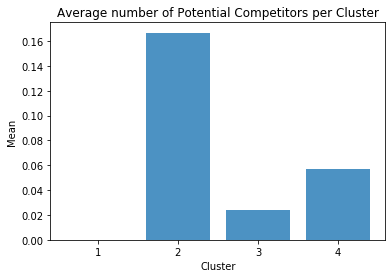

In [73]:

clusters_mean = [df_cluster1['Potential Competition'].mean(),df_cluster2['Potential Competition'].mean(),df_cluster3['Potential Competition'].mean(),
                 df_cluster4['Potential Competition'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Potential Competitors per Cluster')

plt.show()

## Discussion

Based on the data above we have a very large area with no potential competitors at all, shown with purple on the map. This could be further explored by analyzing demographic data. However, the lack of competition could also indicate that this area wouldn't work at all and it's not by the sea, which is an important aspect.

The most promising is cluster number 3, with little competition, but a very nice location. The cluster with the most competition should also be further analyzed, since it could indicate a strong preference and demand for such food by the ihabitants of the area.

Given the fact that there is no direct competition, surveys and other data could be used to make this project more accurate and detailed.